In [45]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
import tushare as ts
import pandas as pd
import numpy as np
import sklearn
from FeatureUtils import *
from sklearn import linear_model
import matplotlib.pyplot as plt 
import datetime
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns

In [53]:
data = ts.get_hist_data("hs300")

In [20]:
#data.head()

## 增加特征

增加 Normalization feature

In [54]:
name = ["open","high","close","low","volume"]
# 增加 Normalization feature
data = NF(data,1,name[0])
data = NF(data,2,name[1])
data = NF(data,3,name[3])
data = NF(data,1,name[4])
# 增加 Combination feature
data = CF(data,5,[name[0],name[1],name[3],"Price"])
data = CF(data,14,[name[0],name[4],name[4],"Volume"])
# 增加 Maximazation & Minimization feature
_,data = MaF(data,5,name[1])
_,data = MaF(data,5,name[4])
_,data = MiF(data,5,name[3]) 
_,data = MiF(data,5,name[4])
# 增加 SP&500 Adj Close
data = sp(data)
# 增加 CCI
data = CCI(data,10)
# 增加 EMV
data = EVM(data,5)
# 增加 MA
data = EWMA(data,5)
# 增加 ROC
data = ROC(data,12)
# 增加 BBands
data = BBANDS(data,20)
# 增加 Force index
data = ForceIndex(data,13)
# 增加 TR & ATR
data = TR(data,[name[1],name[3],name[2]])
data = ATR(data,10)

 # **回归**

## 处理数据

In [4]:
data.head()

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,...,SP500,CCI,EVM,EWMA_5,Rate of Change,Upper BollingerBand,Lower BollingerBand,ForceIndex,TR,ATR
2016-10-28,3347.143,3370.748,3340.126,3337.288,93133312.0,-5.569,-0.17,3355.130,3333.745,3301.799,...,212.539993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.460,NaN
2016-10-27,3351.460,3352.354,3345.695,3335.133,77629848.0,-9.105,-0.27,3352.653,3330.317,3298.576,...,213.169998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.221,NaN
2016-10-26,3365.197,3367.831,3354.800,3349.574,98024784.0,-12.654,-0.38,3347.235,3326.012,3295.847,...,213.740005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.136,NaN
2016-10-25,3367.475,3373.913,3367.454,3356.585,111191696.0,-0.123,-0.00,3339.523,3320.533,3291.439,...,214.169998,NaN,NaN,3356.569323,NaN,NaN,NaN,NaN,19.113,NaN
2016-10-24,3332.512,3382.825,3367.577,3330.967,153014352.0,39.837,1.20,3330.299,3314.443,3285.936,...,214.889999,NaN,NaN,3360.795019,NaN,NaN,NaN,NaN,51.858,NaN


In [6]:
data["y"] = data["close"].shift(1) # 需要估计的Y是第二天的股指的收盘价
data = data.dropna() # 将含有nan的样本剔除 
data.head()

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,...,CCI,EVM,EWMA_5,Rate of Change,Upper BollingerBand,Lower BollingerBand,ForceIndex,TR,ATR,y
2016-09-23,3292.278,3293.916,3275.666,3275.025,57993984.0,-15.455,-0.47,3270.790,3277.322,3297.783,...,34.455296,306.273060,3252.974518,-0.013749,3386.977957,3210.173143,-2.353048e+09,73.633,34.919656,3220.283
2016-09-22,3281.471,3303.199,3291.121,3277.979,75753544.0,24.485,0.75,3263.403,3283.838,3300.493,...,60.099170,377.685207,3265.691712,0.004040,3381.450088,3210.243612,-2.288590e+09,27.533,34.392038,3275.666
2016-09-21,3257.709,3270.902,3266.636,3254.321,59142980.0,9.233,0.28,3257.245,3288.988,3303.028,...,4.985567,294.036899,3266.006502,-0.011861,3373.255839,3209.621461,-6.648854e+08,36.800,34.564035,3291.121
2016-09-20,3264.664,3265.035,3257.403,3252.388,52784208.0,-5.721,-0.17,3256.439,3294.292,3306.536,...,2.084378,349.344911,3263.138498,-0.013699,3360.728837,3211.143363,-2.557131e+09,14.248,33.112890,3266.636
2016-09-19,3242.742,3264.899,3263.124,3242.742,58831080.0,24.395,0.75,3268.567,3299.963,3311.917,...,6.345143,92.083302,3263.133665,-0.011177,3345.408546,3216.018354,-2.325063e+09,22.157,32.330326,3257.403


## 线性回归（lasso）

In [7]:
x_columns = data.columns[:-1]
y_columns = data.columns[-1]

# 将数据按7:2:1的比例分成训练集，测试集和检验集

end_train = datetime.datetime(2016,6,17)

X_train = data[data.index<=end_train][x_columns]
y_train = data[data.index<=end_train][y_columns]

X_test = data[data.index>end_train][x_columns]
y_test = data[data.index>end_train][y_columns]


In [9]:
# 利用k-fold cross validation 选择lasso中的超参数
tscv = TimeSeriesSplit(n_splits=5)
alpha_list = [0,0.01,0.1,1,10]
ini = []
for alpha in alpha_list:
    result = 0
    for train, test in tscv.split(X_train):
        regr = linear_model.Lasso(alpha)
        x = X_train.ix[train]
        y = y_train.ix[train]
        x_ts = X_train.ix[test]
        y_ts = y_train.ix[test]
        regr.fit(x,y)
        result += regr.score(x_ts,y_ts)
    ini.append(result/5)
alpha = alpha_list[np.argmax(ini)]
print alpha

D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
D:\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:465: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
D:\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [22]:
# 再对超参数进行更仔细的选择
alpha_list = np.linspace(0,0.05,20)
ini = []
for alpha in alpha_list:
    result = 0
    for train, test in tscv.split(X_train):
        regr = linear_model.Lasso(alpha)
        x = X_train.ix[train]
        y = y_train.ix[train]
        x_ts = X_train.ix[test]
        y_ts = y_train.ix[test]
        regr.fit(x,y)
        result += regr.score(x_ts,y_ts)
    ini.append(result/5)
alpha = alpha_list[np.argmax(ini)]
print alpha

D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


In [24]:
# 用整个训练数据去训练模型，得到测试集上数据的预测值
regr = linear_model.Lasso(alpha)
regr.fit(X_train,y_train)
y_predict = regr.predict(X_test)

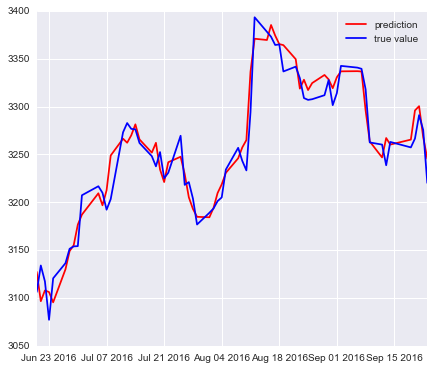

In [36]:
fig = plt.figure(figsize = (7,6))
plt.plot(X_test.index,y_predict,"r",label = "prediction")
plt.plot(X_test.index,y_test,"b",label = "true value")
plt.legend()

# **分类**

In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import itertools


## 处理数据

In [66]:
# 用前一天的数据来预测当前的涨跌情况
# y = 1,代表涨
# y = 0，代表跌
data["y"] = data["close"].diff(-1)
data = data.dropna()
data["y"][data["y"]>0] = 1
data["y"][data["y"]<=0] = 0

In [65]:
data.head()

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,...,CCI,EVM,EWMA_5,Rate of Change,Upper BollingerBand,Lower BollingerBand,ForceIndex,TR,ATR,y
2016-09-26,3267.690,3267.690,3220.283,3220.283,70452184.0,-55.383,-1.69,3262.222,3265.394,3293.349,...,-69.286385,-218.608248,3241.625364,-0.028935,3391.376531,3212.220569,-6.926929e+09,47.407,31.941707,0.0
2016-09-23,3292.278,3293.916,3275.666,3275.025,57993984.0,-15.455,-0.47,3270.790,3277.322,3297.783,...,34.455296,306.273060,3252.974518,-0.013749,3386.977957,3210.173143,-2.353048e+09,73.633,34.919656,0.0
2016-09-22,3281.471,3303.199,3291.121,3277.979,75753544.0,24.485,0.75,3263.403,3283.838,3300.493,...,60.099170,377.685207,3265.691712,0.004040,3381.450088,3210.243612,-2.288590e+09,27.533,34.392038,1.0
2016-09-21,3257.709,3270.902,3266.636,3254.321,59142980.0,9.233,0.28,3257.245,3288.988,3303.028,...,4.985567,294.036899,3266.006502,-0.011861,3373.255839,3209.621461,-6.648854e+08,36.800,34.564035,1.0
2016-09-20,3264.664,3265.035,3257.403,3252.388,52784208.0,-5.721,-0.17,3256.439,3294.292,3306.536,...,2.084378,349.344911,3263.138498,-0.013699,3360.728837,3211.143363,-2.557131e+09,14.248,33.112890,0.0


## Random Forest

In [81]:
x_columns = data.columns[:-1]
y_columns = data.columns[-1]

# 将数据按7:2:1的比例分成训练集，测试集和检验集

end_train = datetime.datetime(2016,6,17)

X_train = data[data.index<=end_train][x_columns]
y_train = data[data.index<=end_train][y_columns]

X_test = data[data.index>end_train][x_columns]
y_test = data[data.index>end_train][y_columns]

# 用cv选择参数
tuned_parameters = [{'n_estimators': range(1,100,14), 'max_features': range(1,10,4),
                     'max_depth': range(1,5,1)}]

clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5,
                       scoring = "precision")
clf.fit(X_train, y_train)
print "Best parameters set found on development set:"
print clf.best_params_


Best parameters set found on development set:
{'max_features': 9, 'n_estimators': 15, 'max_depth': 2}
Grid scores on development set:


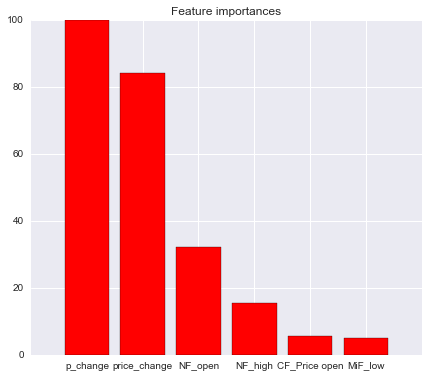

In [108]:
# 用全部训练数据去拟合模型，并画出Feature Importance
forest = RandomForestClassifier(max_features=9,n_estimators=15,max_depth=2)
forest.fit(X_train,y_train)
importances = forest.feature_importances_
importances = importances/max(importances)*100 # 将最重要的Feature的重要性设为100
indices = np.argsort(importances)[::-1]
indices = indices[:6]  # 取Feature Importance 最大的前六个
plt.figure(figsize = (7,6))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices],
       color="r",align="center")
plt.xticks(range(len(indices)), data.columns[indices])
plt.xlim([-1, len(indices)])
plt.show()

Confusion matrix, without normalization
[[33  0]
 [ 0 34]]
Normalized confusion matrix
[[ 1.  0.]
 [ 0.  1.]]


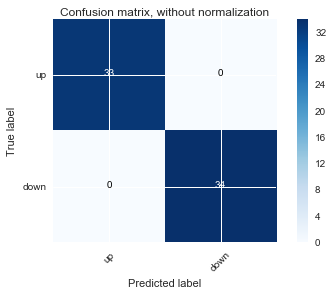

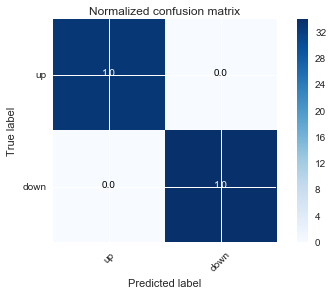

In [112]:
# Confusion Matrix
y_pred = clf.predict(X_test)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names = ["up","down"]
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
